## Table of Contents
* [Load data, explore and clean](#chapter1)

* [Find cutting and bulking date ranges from nutrition dataframe](#chapter2)

* [Plot Calorie intake, weight & skin fold readings vs. time for each bulk/cut phase](#chapter3)

* [Create function that summarizes diet phases](#chapter4)

* [Summarize Data & Plot](#chapter5)

* [Conclusion](#chapter6)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
import datetime
import warnings

warnings.filterwarnings("ignore")

## Load data, explore and clean <a class="anchor" id="chapter1"></a>

In [2]:
# load csv file
nutrition_df = pd.read_csv('Nutrition Data Totals.csv', parse_dates=['Date'])
nutrition_df.head()

,Date,Weight (lbs),Weight Week Avg. (lbs),Weight Week Min. (lbs),Fat (%),Calories,Protein (g),Carbs (g),Fat (g),Vitamin A (IU),...,Riboflavin Vit. B2 (mg),Zinc (mg),Suprailiac skin fold average (mm),Umbilical skin fold average (mm),Thigh skin fold average (mm),Midaxillary skin fold average (mm),Skin fold sum (mm),Notes,Diet,Sleep Duration (h)
0,2016-09-12,157.6,157.1,156.4,10.6,2553.9,197.8,338.5,52.6,5710.0,...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bulking,NaN
1,2016-09-13,157.6,NaN,NaN,10.6,2468.4,164.7,244.1,95.4,21369.5,...,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bulking,NaN
2,2016-09-14,156.4,NaN,NaN,10.0,2569.1,183.4,341.7,61.3,5865.0,...,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bulking,NaN
3,2016-09-15,156.4,NaN,NaN,NaN,2700.0,155.6,275.0,64.0,19295.0,...,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bulking,NaN
4,2016-09-16,157.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bulking,NaN


In [3]:
nutrition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Date                                2285 non-null   datetime64[ns]
 1   Weight (lbs)                        2264 non-null   float64       
 2   Weight Week Avg. (lbs)              327 non-null    float64       
 3   Weight Week Min. (lbs)              327 non-null    float64       
 4   Fat (%)                             36 non-null     float64       
 5   Calories                            2181 non-null   float64       
 6   Protein (g)                         2175 non-null   float64       
 7   Carbs (g)                           2174 non-null   float64       
 8   Fat (g)                             2174 non-null   float64       
 9   Vitamin A (IU)                      2168 non-null   float64       
 10  Vitamin B12 (µg)        

In [4]:
# remove empty columns from nutrition df
empty_nutrition_cols = [col for col in nutrition_df.columns if nutrition_df[col].isnull().all()]
nutrition_df.drop(columns=empty_nutrition_cols, inplace=True)

# remove other unnecessary columns 
cols = ['Weight Week Avg. (lbs)', 'Weight Week Min. (lbs)', 'Fat (%)', 'Vitamin A (IU)', 'Vitamin B12 (µg)',
       'Vitamin B6 (mg)', 'Vitamin C (mg)', 'Vitamin D (IU)', 'Calcium (mg)',
       'Dietary Fiber (g)', 'Sodium (mg)', 'Iron (mg)', 'Potassium (mg)',
       'Magnesium (mg)', 'Phosphorus (mg)', 'Cholestorol (mg)',
       'Vitamin E (IU)', 'Riboflavin Vit. B2 (mg)', 'Zinc (mg)']

nutrition_df.drop(columns=cols, inplace=True)

In [5]:
# Date column indicates the end of a 24 hour eating cycle
# rename Date column to DateEnd to indicate end of the 24 hour window 
nutrition_df.rename(columns={'Date': 'DateEnd'}, inplace=True)

# add column DateBegin to indicate beginning of 24 hour eating window 
nutrition_df['DateBegin'] = nutrition_df['DateEnd'] - pd.DateOffset(hours=24)

# move the DateBegin column to the beginning of the dataframe
col = nutrition_df.pop('DateBegin')
nutrition_df.insert(0, 'DateBegin', col)

In [6]:
# remove DateEnd period from 9/6/21 to 9/12/21, was on vacation, nutritional data was not tracked
VacationBegin = pd.to_datetime('2021-09-04 13:00:00')
VacationEnd = pd.to_datetime('2021-09-12 13:00:00')
nutrition_df = nutrition_df.loc[(nutrition_df['DateBegin'] < VacationBegin) | (nutrition_df['DateEnd'] > VacationEnd)]

In [7]:
# remove dates before cutoff date, this cutoff date is based on less accurate tracking methods used prior to cutoff date
cutoff_date = pd.to_datetime('2018-12-31 13:00:00')
nutrition_df = nutrition_df.loc[nutrition_df['DateBegin'] >= cutoff_date]

# reset dataframe index
nutrition_df.reset_index(drop=True, inplace=True)

In [8]:
# add day of week from DateEnd
nutrition_df['DayOfWeek'] = nutrition_df['DateEnd'].dt.day_name()

In [9]:
# as indicated from the dataframe info above, there are missing values. A good first-order substitute
# for these missing values is to use a rolling average around the date of the missing value. Since calorie/macro intake
# varied based on diet/time of the year, a local average is going to be more accurate than a long-term average.

# fill in missing values with a rolling mean of 3 days prior and 3 days after missing value
nutrition_df['Weight (lbs)'] = nutrition_df['Weight (lbs)'].fillna(nutrition_df['Weight (lbs)'].rolling(7, min_periods=5, center=True).mean())
nutrition_df['Calories'] = nutrition_df['Calories'].fillna(nutrition_df['Calories'].rolling(7, min_periods=5, center=True).mean())
nutrition_df['Protein (g)'] = nutrition_df['Protein (g)'].fillna(nutrition_df['Protein (g)'].rolling(7, min_periods=5, center=True).mean())
nutrition_df['Carbs (g)'] = nutrition_df['Carbs (g)'].fillna(nutrition_df['Carbs (g)'].rolling(7, min_periods=5, center=True).mean())
nutrition_df['Fat (g)'] = nutrition_df['Fat (g)'].fillna(nutrition_df['Fat (g)'].rolling(7, min_periods=5, center=True).mean())

In [10]:
# verify there are no missing values for weight, calories and macronutrients
nutrition_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   DateBegin                          1436 non-null   datetime64[ns]
 1   DateEnd                            1436 non-null   datetime64[ns]
 2   Weight (lbs)                       1436 non-null   float64       
 3   Calories                           1436 non-null   float64       
 4   Protein (g)                        1436 non-null   float64       
 5   Carbs (g)                          1436 non-null   float64       
 6   Fat (g)                            1436 non-null   float64       
 7   Suprailiac skin fold average (mm)  64 non-null     float64       
 8   Umbilical skin fold average (mm)   64 non-null     float64       
 9   Thigh skin fold average (mm)       64 non-null     float64       
 10  Skin fold sum (mm)                 6

In [11]:
# for data visualization purposes, a plot of weekly averages is cleaner and paints a better picture of
# how weight and calorie intake varied over time

# add 7 day rolling average for calorie intake
nutrition_df['Calorie7DayRollingAvg'] = nutrition_df['Calories'].rolling(7, min_periods=7, center=False).mean()

# add 7 day rolling average for weigtht
nutrition_df['Weight7DayRollingAvg'] = nutrition_df['Weight (lbs)'].rolling(7, min_periods=7, center=False).mean()

# add a column for the 7 day difference between any two days
nutrition_df['WeightRollingAvg7DayDiff'] = nutrition_df['Weight7DayRollingAvg'].diff(7)

# add column for ratio of avg weight change to avg calorie intake
nutrition_df['AvgWeeklyWeightChange/AvgWeeklyKcalIntake'] = (nutrition_df['WeightRollingAvg7DayDiff'] / nutrition_df['Calorie7DayRollingAvg']) * 1000

## Find cutting and bulking date ranges from nutrition dataframe <a class="anchor" id="chapter2"></a>

In [12]:
# get dataframe with cutting and bulking only. Maintenance has not been a significant
# part of nutritional stradegy since I started tracking
cut_bulk_df = nutrition_df.loc[(nutrition_df['Diet'] != 'Maintenance')]
cut_bulk_df.reset_index(drop=True, inplace=True)

# create an indicator for diet = 'Bulking'
cut_bulk_df.loc[cut_bulk_df['Diet'] == 'Bulking', 'BulkingIndicator'] = 1
cut_bulk_df.loc[cut_bulk_df['Diet'] == 'Cutting', 'BulkingIndicator'] = 0

# get the indeces where diet transitioned from cut to bulk
bulk_begin = np.where(cut_bulk_df['BulkingIndicator'].diff() == 1)[0]
# end dates for cutss are the index prior
cut_end = bulk_begin - 1 

# get the indeces where diet transitioned from bulk to cut
cut_begin = np.where(cut_bulk_df['BulkingIndicator'].diff() == -1)[0]
# end dates for bulks are the index prior
bulk_end = cut_begin - 1

# if first index num of bulk_begin is less than
# first index num of cut_begin, row index 0 of dataframe is cutting
if bulk_begin[0] < cut_begin[0]:
    # add 0 to cut_begin
    cut_begin = np.insert(cut_begin, 0, 0)
# else, beginning of diet in dataframe is bulk
else:
    bulk_begin = np.insert(bulk_begin, 0, 0)
    
# if last index num of bulk_begin is less than
# last index num of cut_begin, last index row of dataframe is cutting
if bulk_begin[-1] < cut_begin[-1]:
    cut_end = np.append(cut_end, cut_bulk_df.index[-1])
# else, end of diet in dataframe is bulk
else:
    bulk_end = np.append(bulk_end, cut_bulk_df.index[-1])

# get dates from indeces
bulk_begin_dates = cut_bulk_df.iloc[bulk_begin]['DateBegin'].to_list()
bulk_end_dates = cut_bulk_df.iloc[bulk_end]['DateEnd'].to_list()

cut_begin_dates = cut_bulk_df.iloc[cut_begin]['DateBegin'].to_list()
cut_end_dates = cut_bulk_df.iloc[cut_end]['DateEnd'].to_list()

# create dictionary to store the dates
dates_dict = {'Cut' : (cut_begin_dates, cut_end_dates), 'Bulk' : (bulk_begin_dates, bulk_end_dates)}

# get total number of cuts and bulks
num_cuts = len(cut_begin_dates)
num_bulks = len(bulk_begin_dates)

## Plot Calorie intake, weight & skin fold readings vs. time for each bulk/cut phase <a class="anchor" id="chapter3"></a>

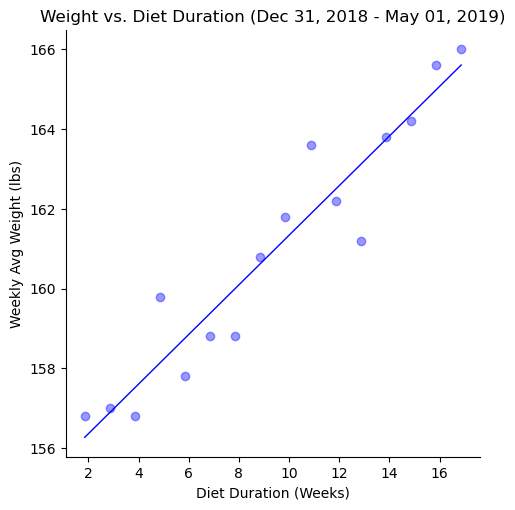

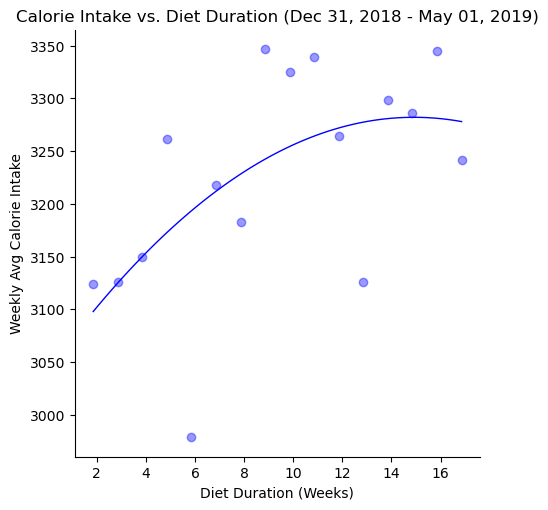

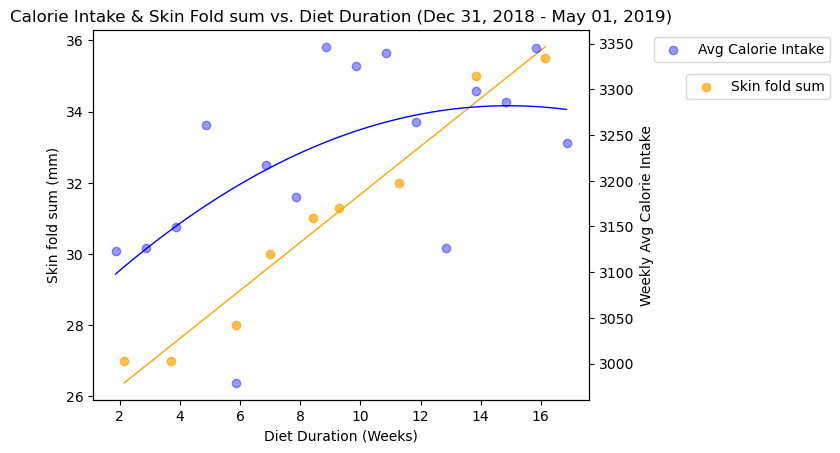

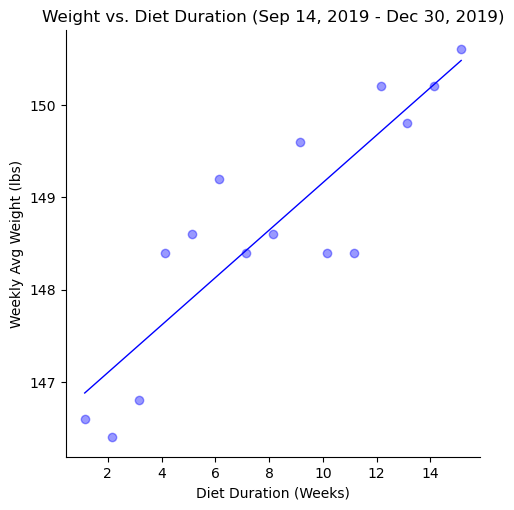

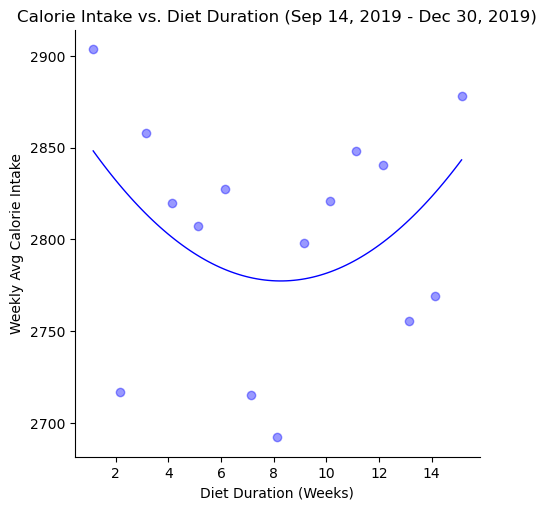

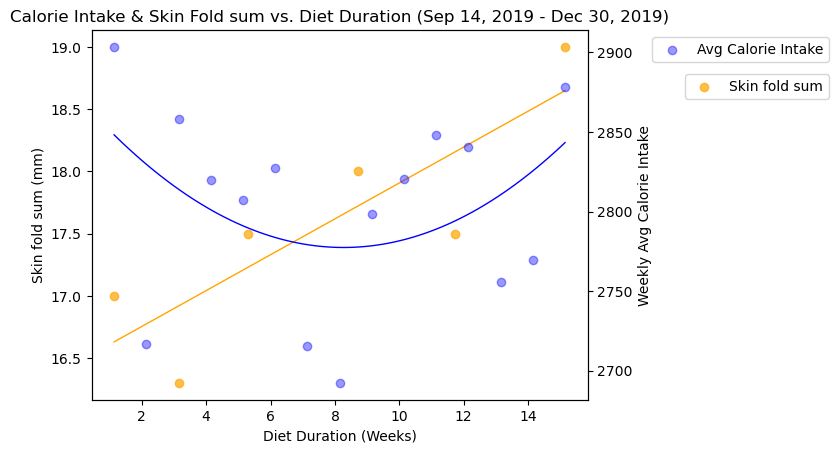

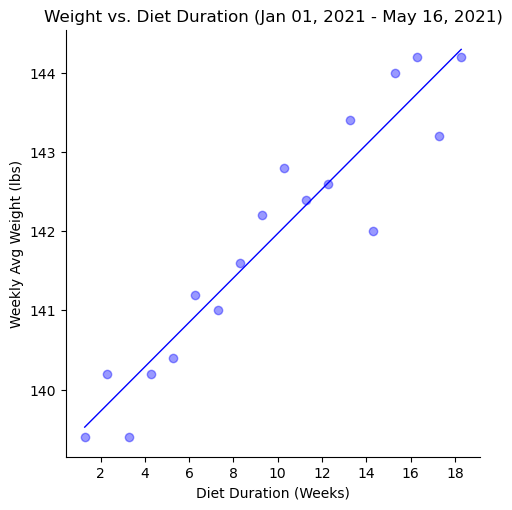

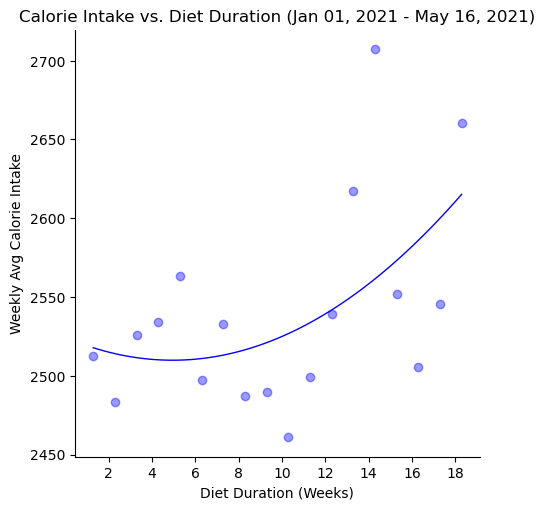

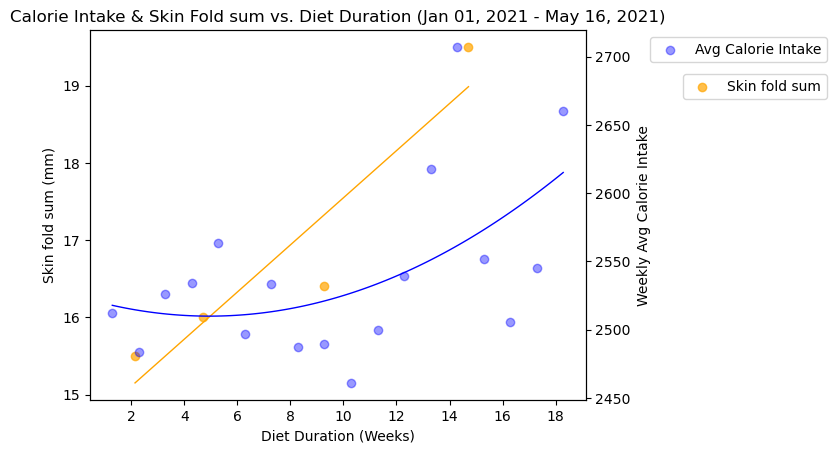

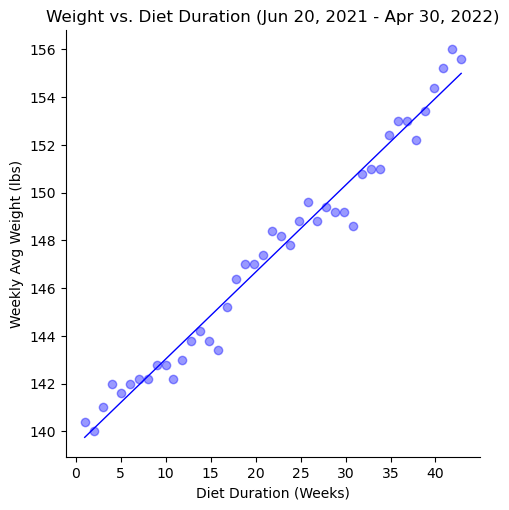

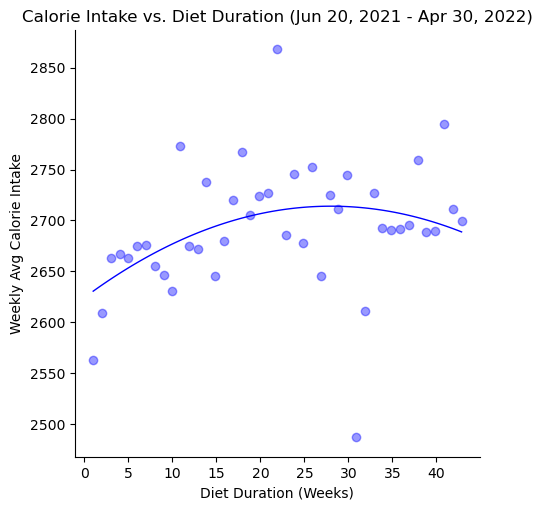

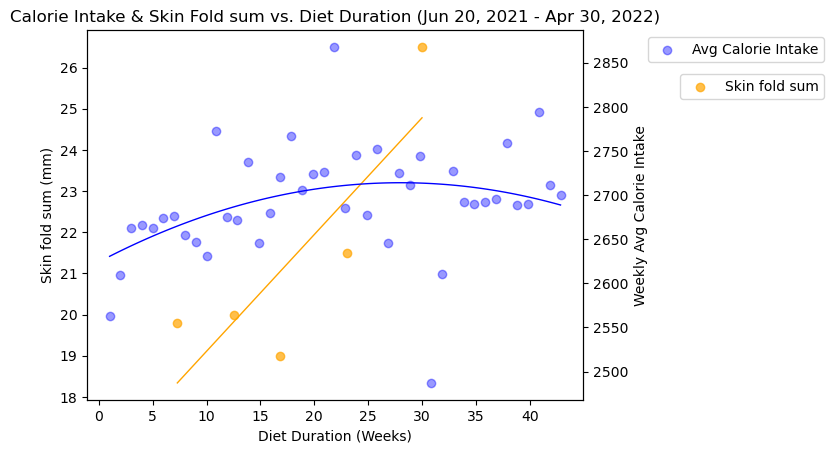

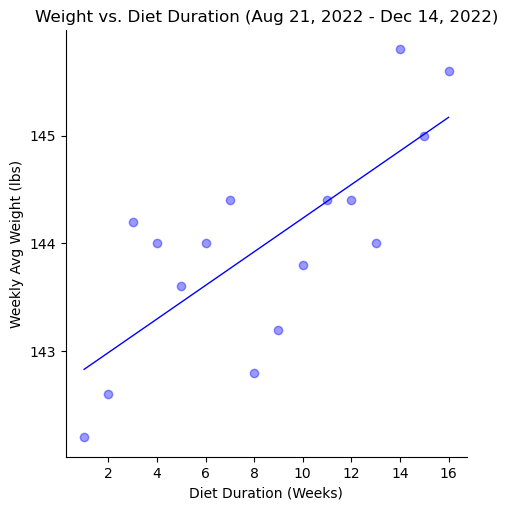

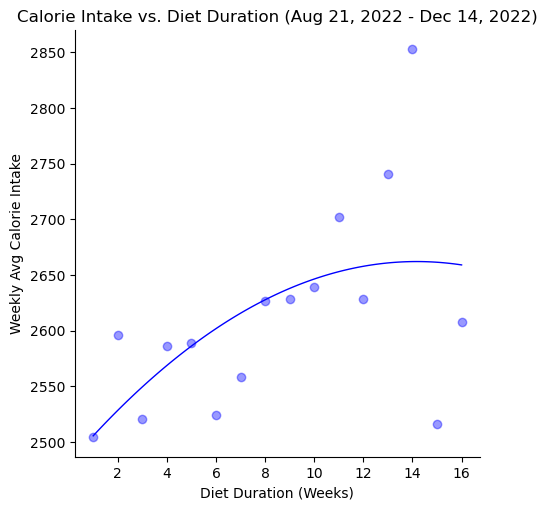

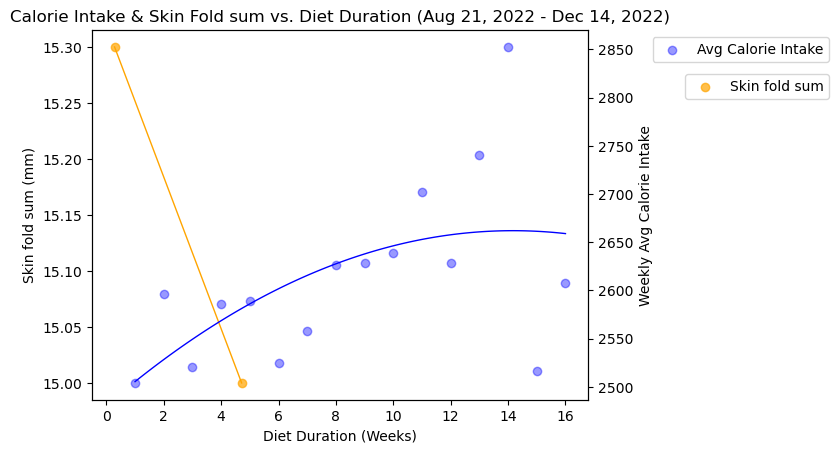

In [13]:
# for each bulk plot calorie/weight/skinfold meansurements over time
for i in range(num_bulks):
    df = nutrition_df.loc[(nutrition_df['DateBegin'] >= bulk_begin_dates[i]) \
        & (nutrition_df['DateEnd'] <= bulk_end_dates[i])]
    df.reset_index(drop=True, inplace=True)
    # add day count to dataframe
    df['Days'] = df.index
    df['Week'] = df['Days'] / 7
    # create dataframe with only monday data for plotting
    df_monday = df.loc[(df['DayOfWeek'] == 'Monday')]
    # remove first row, this will contain average data from previous diet
    df_monday = df_monday.iloc[1:]
    # create string for diet timeframe
    time_frame = f'{bulk_begin_dates[i]:%b %d, %Y} - {bulk_end_dates[i]:%b %d, %Y}'
    # create plot for weekly average weight vs. num days of diet
    f = sns.lmplot(x='Week', y='Weight (lbs)', data=df_monday, 
                   scatter=True, order=1, ci=None, line_kws={'color':'b', 'linewidth':1}, scatter_kws={'alpha':0.4, 'color':'b'})
    # relabel axes & adjust params
    f.set(ylabel='Weekly Avg Weight (lbs)', xlabel='Diet Duration (Weeks)',
          title=f'Weight vs. Diet Duration ({time_frame})')
    plt.locator_params(axis="both", integer=True)
    plt.locator_params(axis='x', nbins=10)
    
    # create plot for weekly average calorie intake vs. num days of diet
    g = sns.lmplot(x='Week', y='Calorie7DayRollingAvg', data=df_monday, 
                   scatter=True, order=2, ci=None, line_kws={'color':'b', 'linewidth':1}, scatter_kws={'alpha':0.4, 'color':'b'})
    g.set(ylabel='Weekly Avg Calorie Intake', xlabel='Diet Duration (Weeks)',
          title=f'Calorie Intake vs. Diet Duration ({time_frame})')
    plt.locator_params(axis="both", integer=True)
    plt.locator_params(axis='x', nbins=10)
    
    # create dual plot for skin fold measurements and average calorie intake vs. num days of diet
    fig, ax = plt.subplots()
    h1 = sns.regplot(x='Week', y='Skin fold sum (mm)', data=df, color="orange",
                    ci=None, label='Skin fold sum', line_kws={'linewidth':1}, scatter_kws={'alpha':0.7})
    plt.legend(loc=1, bbox_to_anchor=(1.5,0.9))
    ax.set(xlabel='Diet Duration (Weeks)')
    ax2 = ax.twinx()
    h2 = sns.regplot(x='Week', y='Calorie7DayRollingAvg', data=df_monday, color="b",
                     order=2, ci=None, ax=ax2, label='Avg Calorie Intake', line_kws={'linewidth':1}, scatter_kws={'alpha':0.4})
    h2.set(title=f'Calorie Intake & Skin Fold sum vs. Diet Duration ({time_frame})')
    ax2.set(ylabel='Weekly Avg Calorie Intake')
    plt.grid(False)
    plt.legend(loc=1, bbox_to_anchor=(1.5,1))
    plt.locator_params(axis="both", integer=True)
    plt.locator_params(axis='x', nbins=10)

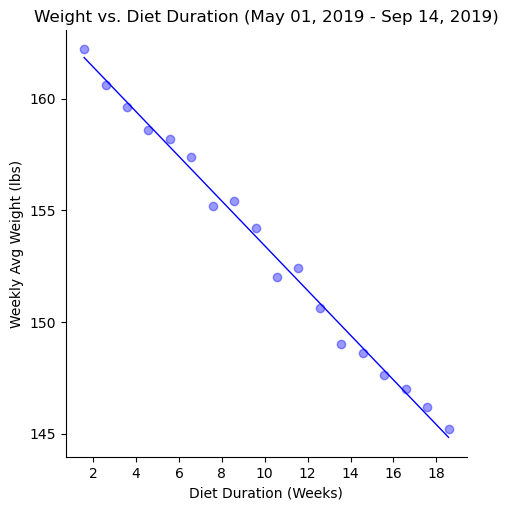

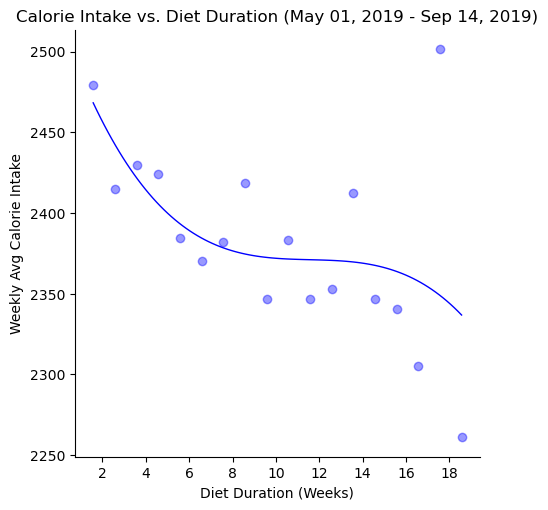

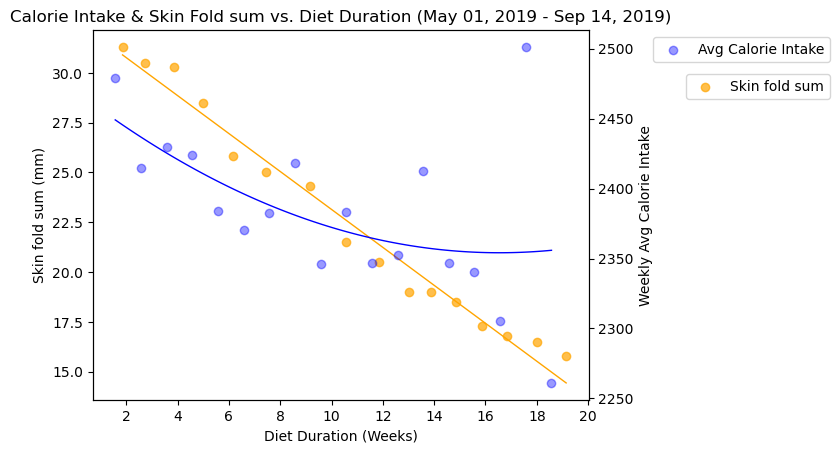

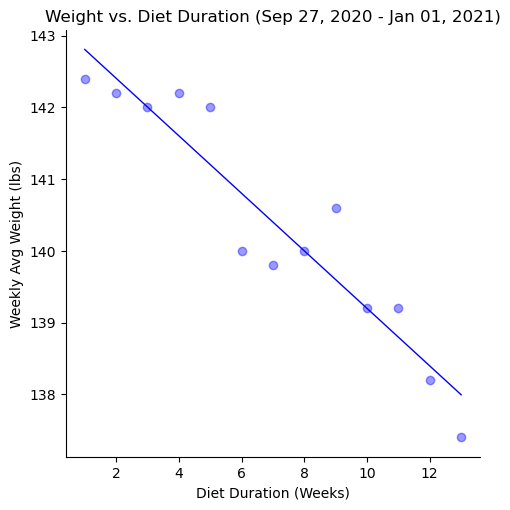

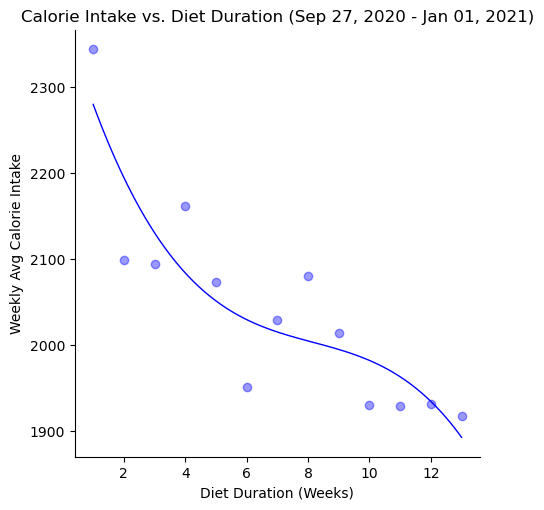

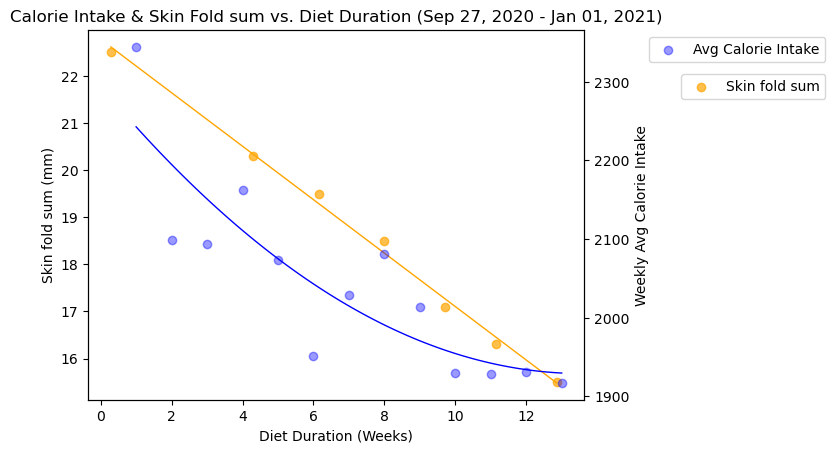

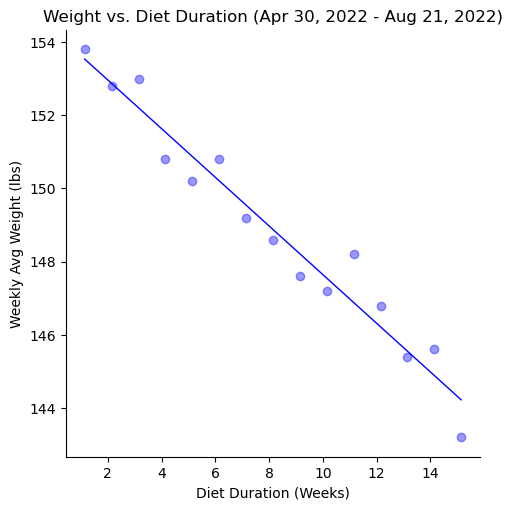

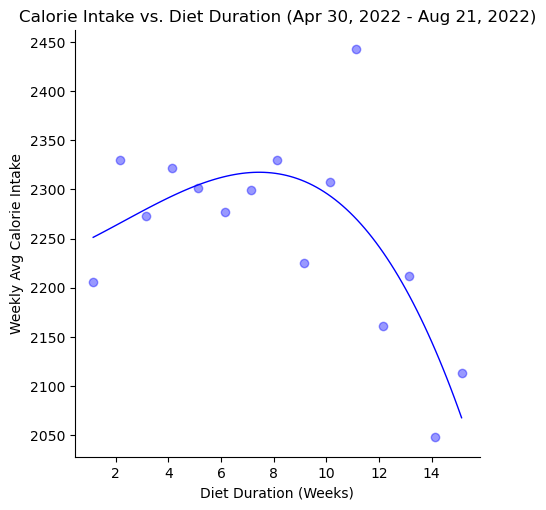

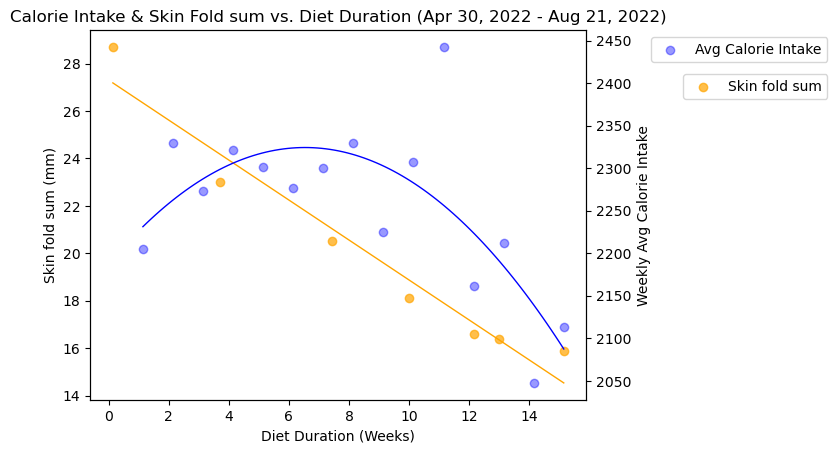

In [14]:
# for each cut plot calorie/weight/skinfold meansurements over time
for i in range(num_cuts):
    # leave out short cut
    if i == 2:
        pass
    else:
        df = nutrition_df.loc[(nutrition_df['DateBegin'] >= cut_begin_dates[i]) \
            & (nutrition_df['DateEnd'] <= cut_end_dates[i])]
        df.reset_index(drop=True, inplace=True)
        # add day count to dataframe
        df['Days'] = df.index
        df['Week'] = df['Days'] / 7
        # create dataframe with only monday data for plotting
        df_monday = df.loc[(df['DayOfWeek'] == 'Monday')]
        # remove first row, this will contain average data from previous diet
        df_monday = df_monday.iloc[1:]
        # create string for diet timeframe
        time_frame = f'{cut_begin_dates[i]:%b %d, %Y} - {cut_end_dates[i]:%b %d, %Y}'
        # create plot for weekly average weight vs. num days of diet
        f = sns.lmplot(x='Week', y='Weight (lbs)', data=df_monday, 
                       scatter=True, order=1, ci=None, line_kws={'color':'b', 'linewidth':1}, scatter_kws={'alpha':0.4, 'color':'b'})
        # relabel axes
        f.set(ylabel='Weekly Avg Weight (lbs)', xlabel='Diet Duration (Weeks)',
              title=f'Weight vs. Diet Duration ({time_frame})')
        plt.locator_params(axis="both", integer=True)
        plt.locator_params(axis='x', nbins=10)
        
        # create plot for weekly average calorie intake vs. num days of diet
        g = sns.lmplot(x='Week', y='Calorie7DayRollingAvg', data=df_monday, 
                       scatter=True, order=3, ci=None, line_kws={'color':'b', 'linewidth':1}, scatter_kws={'alpha':0.4, 'color':'b'})
        g.set(ylabel='Weekly Avg Calorie Intake', xlabel='Diet Duration (Weeks)',
              title=f'Calorie Intake vs. Diet Duration ({time_frame})')
        plt.locator_params(axis="both", integer=True)
        plt.locator_params(axis='x', nbins=10)
        
        # create dual plot for skin fold measurements and average calorie intake vs. num days of diet
        fig, ax = plt.subplots()
        h1 = sns.regplot(x='Week', y='Skin fold sum (mm)', data=df, color="orange",
                        ci=None, label='Skin fold sum', line_kws={'linewidth':1}, scatter_kws={'alpha':0.7})
        plt.legend(loc=1, bbox_to_anchor=(1.5,0.9))
        ax.set(xlabel='Diet Duration (Weeks)')
        ax2 = ax.twinx()
        h2 = sns.regplot(x='Week', y='Calorie7DayRollingAvg', data=df_monday, color="b",
                         order=2, ci=None, ax=ax2, label='Avg Calorie Intake', line_kws={'linewidth':1}, scatter_kws={'alpha':0.4})
        h2.set(title=f'Calorie Intake & Skin Fold sum vs. Diet Duration ({time_frame})')
        ax2.set(ylabel='Weekly Avg Calorie Intake')
        plt.grid(False)
        plt.legend(loc=1, bbox_to_anchor=(1.5,1))
        plt.locator_params(axis="both", integer=True)
        plt.locator_params(axis='x', nbins=10)

## Create function that summarizes diet phases <a class="anchor" id="chapter4"></a>

In [15]:
# generate summary dataframe

def get_summary_dataframe(sub_periods, create_csv=False):
    '''
    Generates a dataframe that creates a compact summary
    dataframe that aggregates nutrition & self data over the course
    of a diet. The function can also break each diet phase up
    into sub periods.

    Parameters
    ----------
    sub_periods : (int) number of sub periods to break each diet phase into

    create_csv : (bool) whether or not to save the summary dataframe as a csv files
        
    Returns
    -------
    summary dataframe

    '''

    # create a dictionary to store the data for each diet and each period within the diet
    df_dict = {}
    
    # cycle through each diet and retrieve the data for each, broken up into p sub_periods
    for diet in dates_dict.keys():
        df_dict[diet] = {}
        for i in range(len(dates_dict[diet][0])):
            # create nested dirionary for each cut
            df_dict[diet][i + 1] = {}
            # filter dataframe for diet timeframe
            if diet == 'Cut':
                df = nutrition_df.loc[(nutrition_df['DateBegin'] >= cut_begin_dates[i]) \
                    & (nutrition_df['DateEnd'] <= cut_end_dates[i])]
                # create timeframe string to add to dataframe
                time_frame = f'{cut_begin_dates[i]:%b %d, %Y} \n- {cut_end_dates[i]:%b %d, %Y}'
            else:
                df = nutrition_df.loc[(nutrition_df['DateBegin'] >= bulk_begin_dates[i]) \
                    & (nutrition_df['DateEnd'] <= bulk_end_dates[i])]
                # create timeframe string to add to dataframe
                time_frame = f'{bulk_begin_dates[i]:%b %d, %Y} \n- {bulk_end_dates[i]:%b %d, %Y}'
            
            df.reset_index(drop=True, inplace=True)
            # split df into even sub_periods
            df_diet_list = np.array_split(df, sub_periods)
            # for each period retrive nutrional weight and date data
            for p in range(sub_periods):
                total_calories = df_diet_list[p]['Calories'].sum()
                num_days_period = df_diet_list[p].shape[0]
                calorie_avg = total_calories / num_days_period
                weight_begin = df_diet_list[p]['Weight (lbs)'].head(7).mean()
                date_begin = df_diet_list[p]['DateBegin'].min()
                date_end = df_diet_list[p]['DateEnd'].max()
                # subtract 1 pound from weight begin if it is the beginning of cut diet due to initial water retention and GI loss
                if p == 0 and diet =='Cut':
                    weight_begin -= 1
                # add 1 pound to weight begin if it is the beginning of bulk diet due to initial water retention and GI addition
                elif p == 0 and diet =='Bulk':
                    weight_begin += 1
                weight_end = df_diet_list[p]['Weight (lbs)'].tail(7).mean()
                weight_change = weight_end - weight_begin
                # retrieve skinfold sum measurements
                skinfolds = df_diet_list[p].loc[(df_diet_list[p]['Skin fold sum (mm)'].notnull())]['Skin fold sum (mm)'].to_list()    
                # get beginning and final skin fold measurment sum
                if len(skinfolds) == 1 or len(skinfolds) == 0:
                    skinfold_initial = np.nan
                    skinfold_final = np.nan
                    skinfold_change = np.nan
                else:
                    skinfold_initial = skinfolds[0]
                    skinfold_final = skinfolds[-1]
                    skinfold_change = skinfold_final - skinfold_initial
                df_dict[diet][i + 1][p + 1] = [date_begin, date_end, weight_begin, weight_end,
                                         weight_change, total_calories, calorie_avg, skinfold_initial,
                                         skinfold_final, skinfold_change, num_days_period]
            
    # create list to store dataframes created below
    df_list = []       
    
    # for each total diet timeframe, create a dataframe for each sub period
    for diet in df_dict.keys():
        for n in df_dict[diet].keys():
            diet_df = pd.DataFrame.from_dict(df_dict[diet][n], orient='index',
                    columns=['DateBegin', 'DateEnd', 'WeightBegin (lbs)', 'WeightEnd (lbs)', 'WeightChange (lbs)',
                             'CalorieTotal', 'CalorieDailyAvg', 'SkinFoldSumInitial (mm)',
                             'SkinFoldSumFinal (mm)', 'SkinFoldSumChange (mm)', 'TotalDays'])
            # add diet and sub period columns
            diet_df['Diet'] = diet
            diet_df['DietSubPeriod'] = diet_df.index
            # reorganize dataframe columns
            diet_df = diet_df[['Diet','DietSubPeriod', 'DateBegin', 'DateEnd', 'TotalDays', 'WeightBegin (lbs)', 
                               'WeightEnd (lbs)', 'WeightChange (lbs)', 'CalorieTotal', 'CalorieDailyAvg', 
                               'SkinFoldSumInitial (mm)', 'SkinFoldSumFinal (mm)', 'SkinFoldSumChange (mm)']]
            df_list.append(diet_df)
    
    # concatenate all dataframes
    df_summary = pd.concat(df_list)
    # sort dataframe by date and diet
    df_summary.sort_values(by=['DateBegin', 'Diet'], inplace=True)
    # if sub_periods = 1, delete the DietSubPeriod column,
    if sub_periods == 1:
        df_summary.drop(columns=['DietSubPeriod'], inplace=True)
    # drop CalorieTotal from dataframe
    df_summary.drop(columns=['CalorieTotal'], inplace=True)
    # round numerical values in dataframe to 1 decimal
    df_summary = df_summary.round(1)
    # reformat dates to more readable version
    df_summary['DateBegin'] = df_summary['DateBegin'].dt.strftime('%b %d,%Y %H:%M%p')
    df_summary['DateEnd'] = df_summary['DateEnd'].dt.strftime('%b %d,%Y %H:%M%p')
    # reset index
    df_summary.reset_index(drop=True, inplace=True)
    
    # create csv file if indicated
    if create_csv:
        df_summary.to_csv('summary.csv', index= False)

    return df_summary

## Summarize Data & Plot <a class="anchor" id="chapter5"></a>

In [16]:
summary_df_1 = get_summary_dataframe(1)
summary_df_1.head()

,Diet,DateBegin,DateEnd,TotalDays,WeightBegin (lbs),WeightEnd (lbs),WeightChange (lbs),CalorieDailyAvg,SkinFoldSumInitial (mm),SkinFoldSumFinal (mm),SkinFoldSumChange (mm)
0,Bulk,"Dec 31,2018 13:00PM","May 01,2019 13:00PM",121,158.0,166.1,8.1,3214.0,27.0,35.5,8.5
1,Cut,"May 01,2019 13:00PM","Sep 14,2019 13:00PM",136,163.4,145.5,-17.9,2377.0,31.3,15.8,-15.5
2,Bulk,"Sep 14,2019 13:00PM","Dec 30,2019 13:00PM",107,147.3,150.9,3.7,2802.0,17.0,19.0,2.0
3,Cut,"Sep 27,2020 13:00PM","Jan 01,2021 13:00PM",96,142.0,137.5,-4.4,2033.2,22.5,15.5,-7.0
4,Bulk,"Jan 01,2021 13:00PM","May 16,2021 13:00PM",135,139.3,142.7,3.4,2534.9,15.5,19.5,4.0


[Text(0.5, 1.0, 'Avg Calorie intake vs. Diet')]

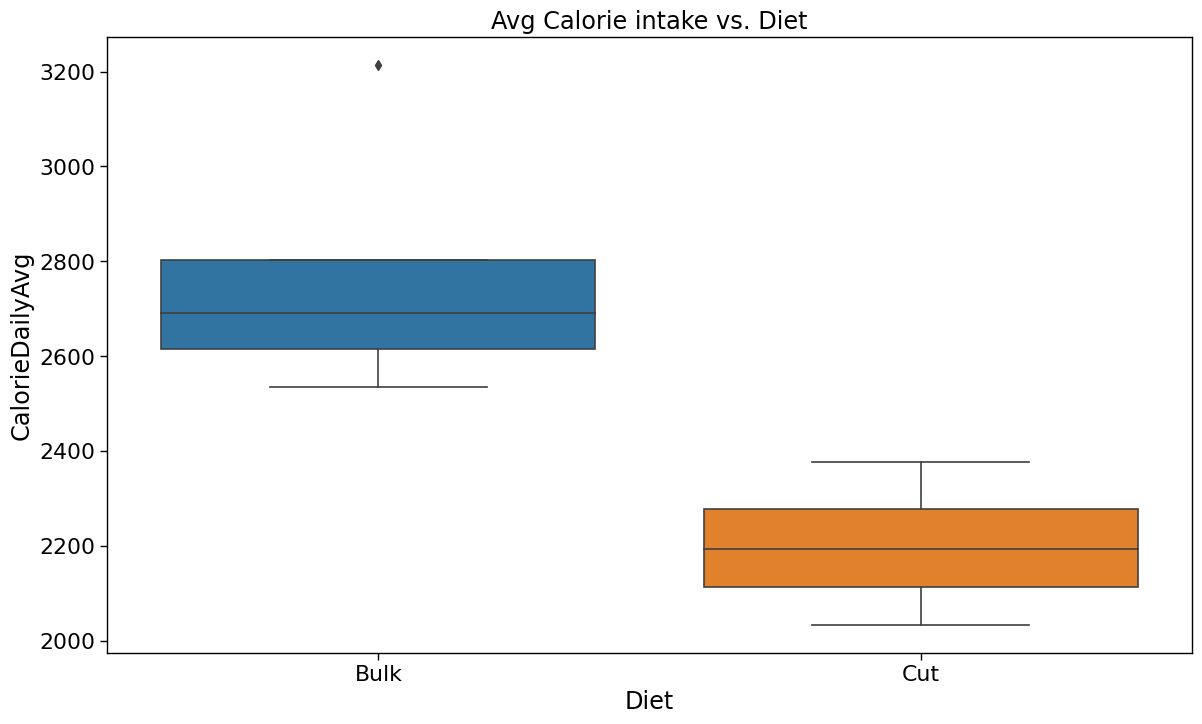

In [17]:
# plot some summary dataframe results
sns.set_context('paper', font_scale=1.8)
plt.rcParams["figure.figsize"] = (14, 8)

p = sns.boxplot(x='Diet', y="CalorieDailyAvg", data=summary_df_1)
p.set(title='Avg Calorie intake vs. Diet')

[Text(0.5, 1.0, 'Weight Change vs. Diet')]

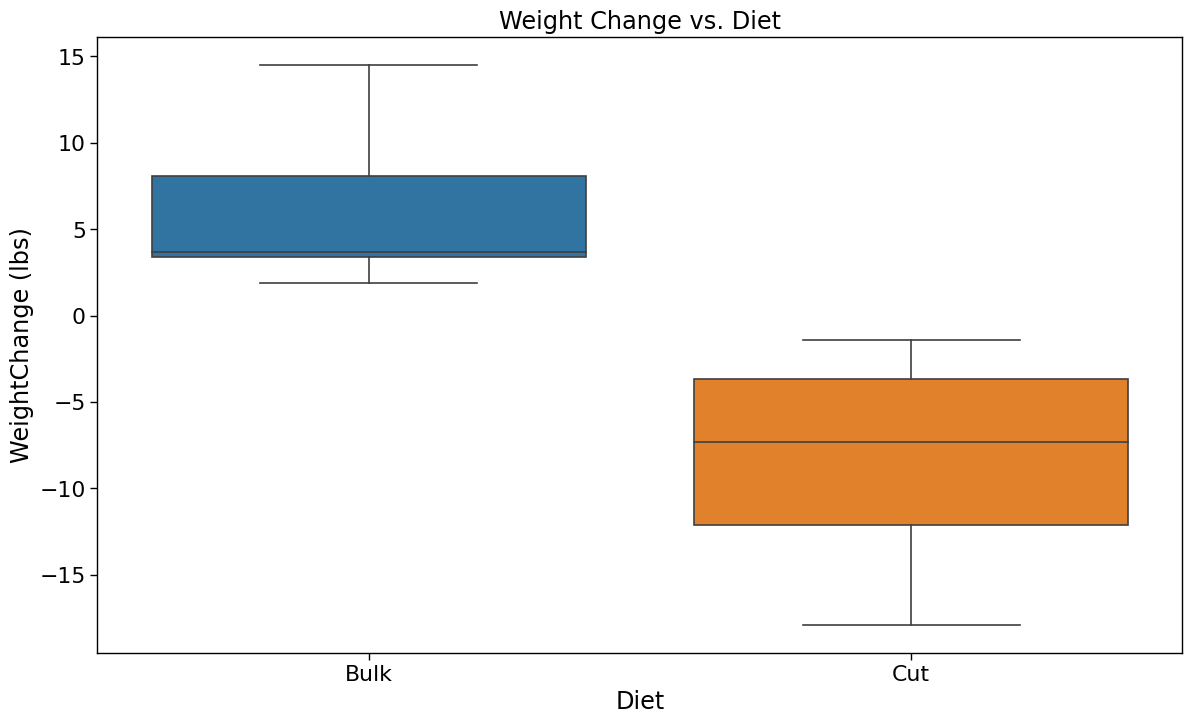

In [18]:
u = sns.boxplot(x='Diet', y="WeightChange (lbs)", data=summary_df_1)
u.set(title='Weight Change vs. Diet')

[Text(0.5, 1.0, 'Length of Diet'), Text(0, 0.5, 'Diet Duration (Days)')]

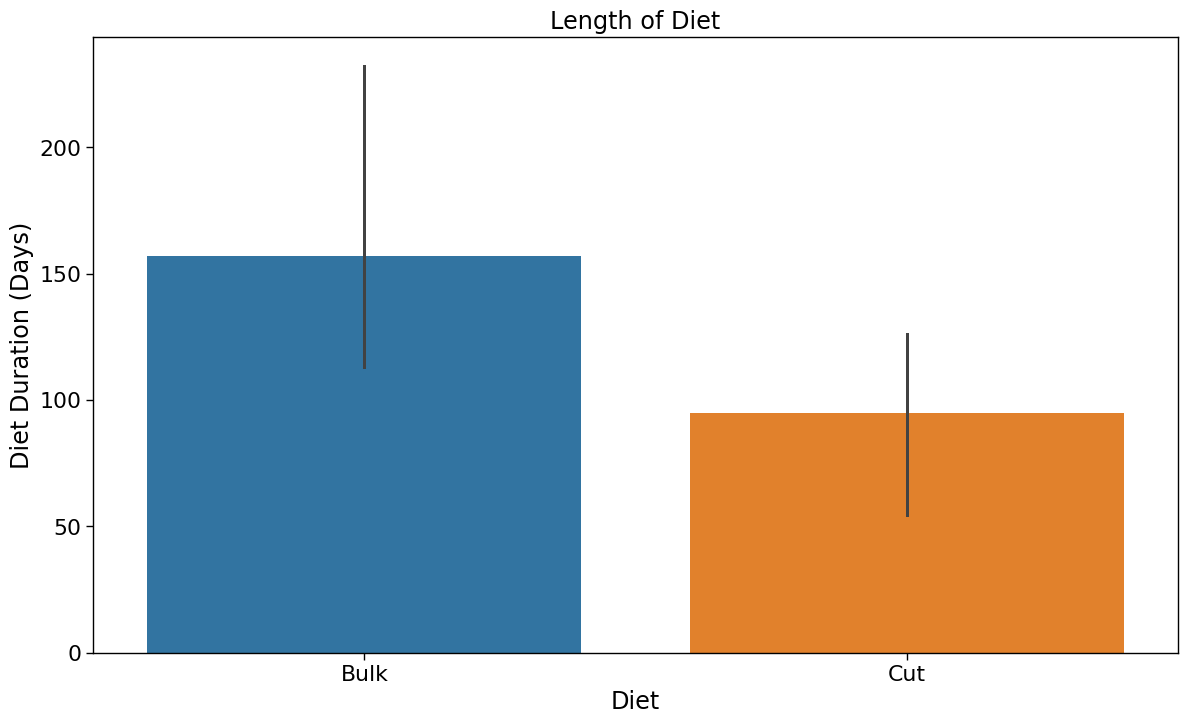

In [19]:
x = sns.barplot(x='Diet', y="TotalDays", data=summary_df_1)
x.set(title='Length of Diet', ylabel='Diet Duration (Days)')

In [20]:
# generate summary dataframe that breaks each diet into two periods
summary_df_2 = get_summary_dataframe(2)
summary_df_2.head()

,Diet,DietSubPeriod,DateBegin,DateEnd,TotalDays,WeightBegin (lbs),WeightEnd (lbs),WeightChange (lbs),CalorieDailyAvg,SkinFoldSumInitial (mm),SkinFoldSumFinal (mm),SkinFoldSumChange (mm)
0,Bulk,1,"Dec 31,2018 13:00PM","Mar 02,2019 13:00PM",61,158.0,160.2,2.2,3148.4,27.0,31.0,4.0
1,Bulk,2,"Mar 02,2019 13:00PM","May 01,2019 13:00PM",60,161.6,166.1,4.5,3280.7,31.3,35.5,4.2
2,Cut,1,"May 01,2019 13:00PM","Jul 08,2019 13:00PM",68,163.4,154.9,-8.5,2406.1,31.3,24.3,-7.0
3,Cut,2,"Jul 08,2019 13:00PM","Sep 14,2019 13:00PM",68,153.1,145.5,-7.6,2347.8,21.5,15.8,-5.7
4,Bulk,1,"Sep 14,2019 13:00PM","Nov 07,2019 13:00PM",54,147.3,148.4,1.1,2794.6,17.0,17.5,0.5


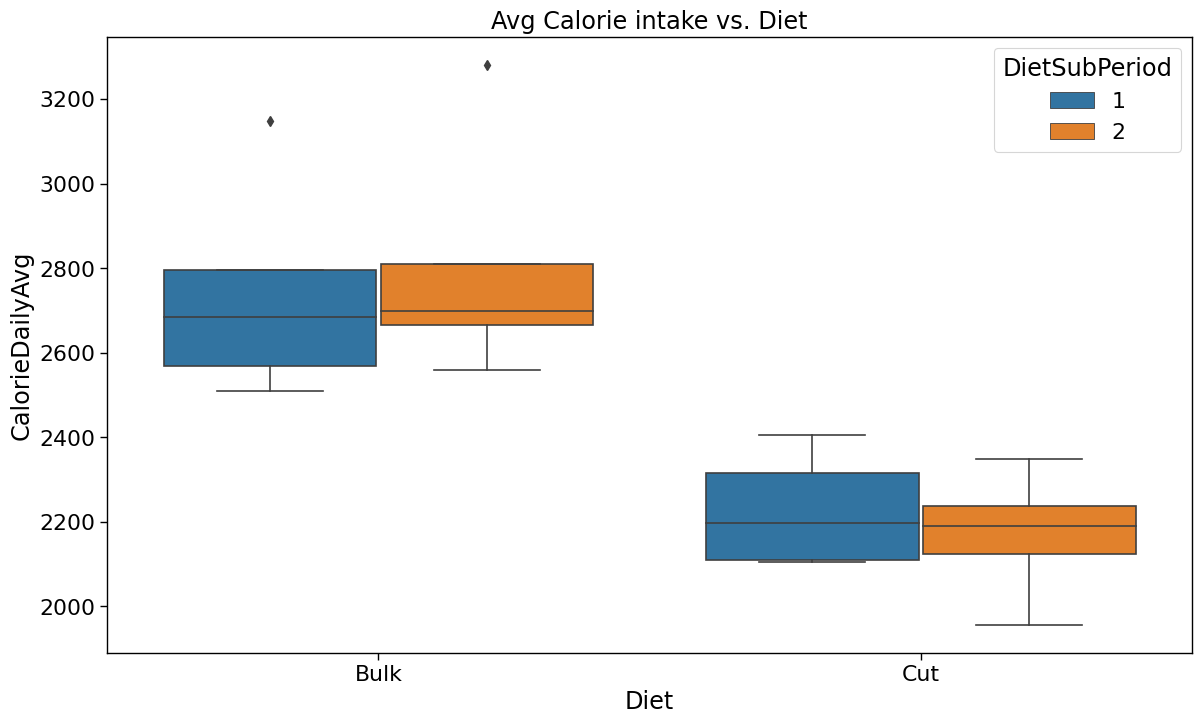

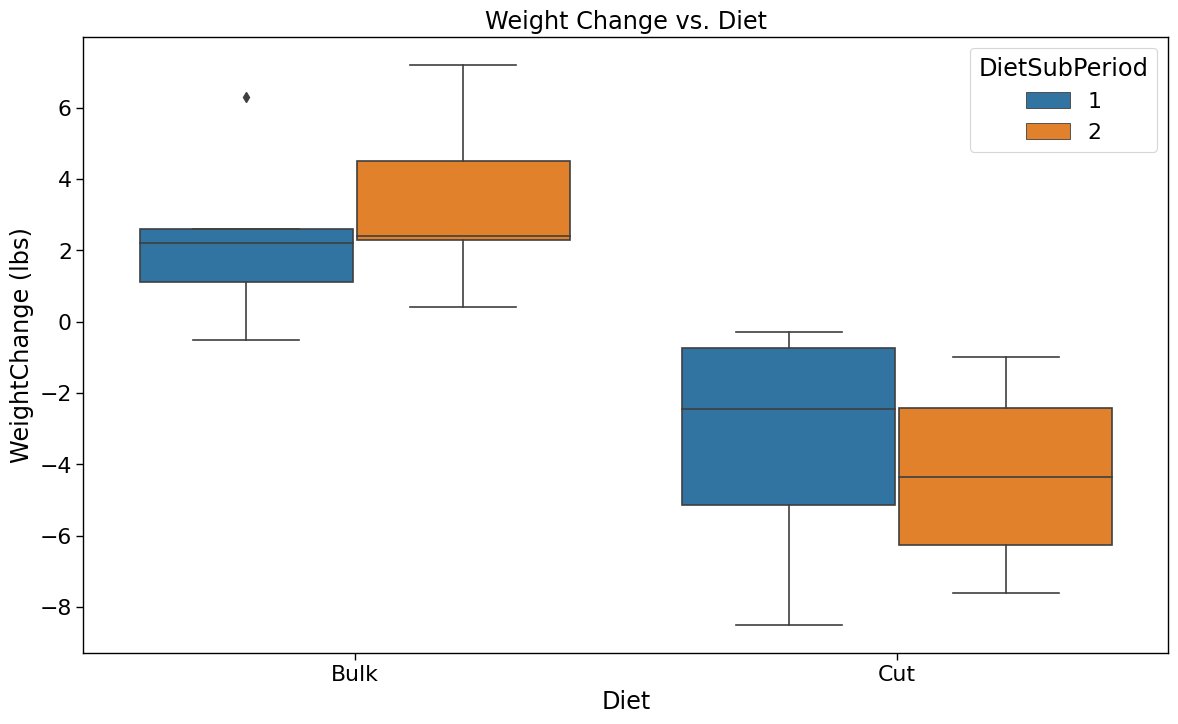

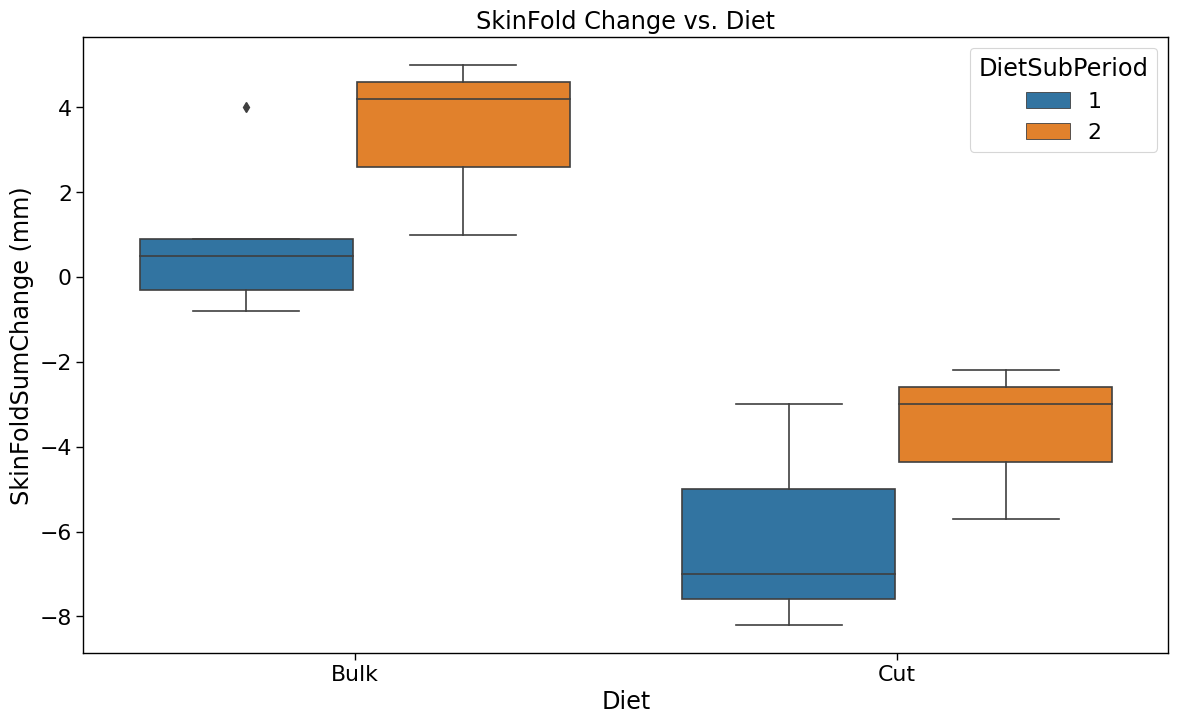

In [21]:
p = sns.boxplot(x='Diet', y="CalorieDailyAvg", hue='DietSubPeriod', data=summary_df_2)
p.set(title='Avg Calorie intake vs. Diet')
plt.show()

u = sns.boxplot(x='Diet', y="WeightChange (lbs)", hue='DietSubPeriod', data=summary_df_2)
u.set(title='Weight Change vs. Diet')
plt.show()

r = sns.boxplot(x='Diet', y="SkinFoldSumChange (mm)", hue='DietSubPeriod', data=summary_df_2)
r.set(title='SkinFold Change vs. Diet')
plt.show()

In [22]:
# generate summary dataframe that breaks each diet into three periods
summary_df_3 = get_summary_dataframe(3)
summary_df_3.head()

,Diet,DietSubPeriod,DateBegin,DateEnd,TotalDays,WeightBegin (lbs),WeightEnd (lbs),WeightChange (lbs),CalorieDailyAvg,SkinFoldSumInitial (mm),SkinFoldSumFinal (mm),SkinFoldSumChange (mm)
0,Bulk,1,"Dec 31,2018 13:00PM","Feb 10,2019 13:00PM",41,158.0,159.2,1.2,3127.5,27.0,27.0,0.0
1,Bulk,2,"Feb 10,2019 13:00PM","Mar 22,2019 13:00PM",40,159.6,163.0,3.4,3260.4,28.0,32.0,4.0
2,Bulk,3,"Mar 22,2019 13:00PM","May 01,2019 13:00PM",40,163.0,166.1,3.1,3256.3,35.0,35.5,0.5
3,Cut,1,"May 01,2019 13:00PM","Jun 16,2019 13:00PM",46,163.4,158.0,-5.4,2418.2,31.3,25.8,-5.5
4,Cut,2,"Jun 16,2019 13:00PM","Jul 31,2019 13:00PM",45,156.6,150.9,-5.7,2371.1,25.0,20.5,-4.5


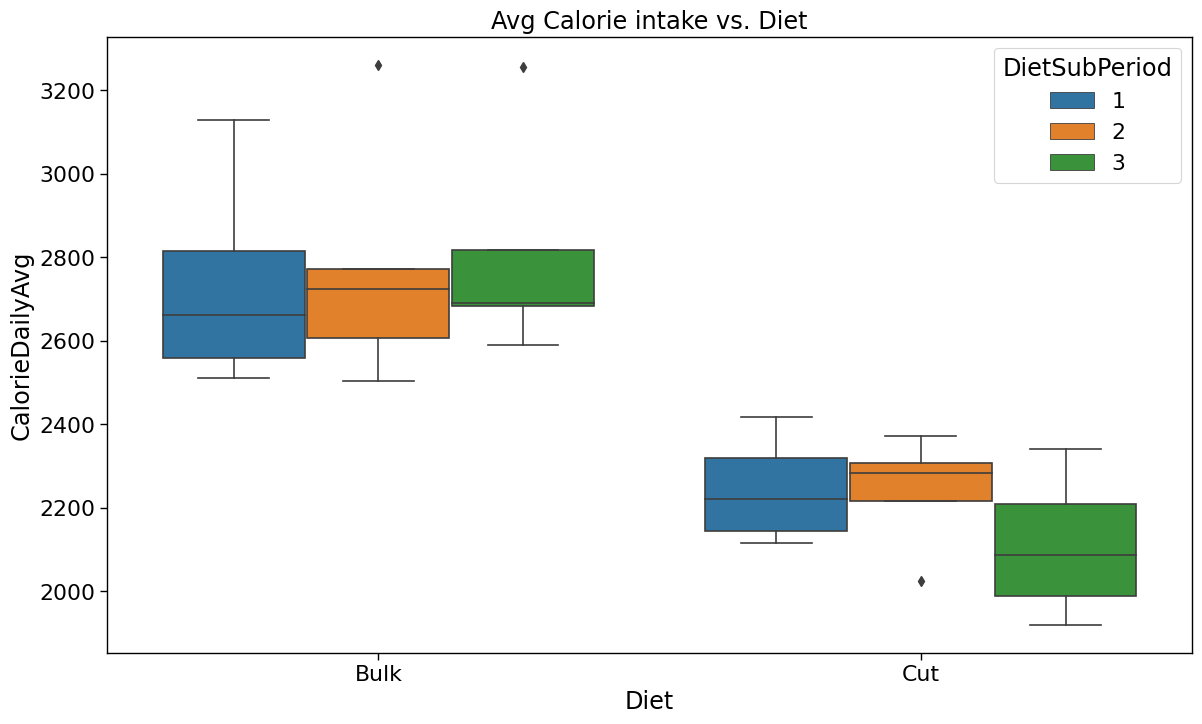

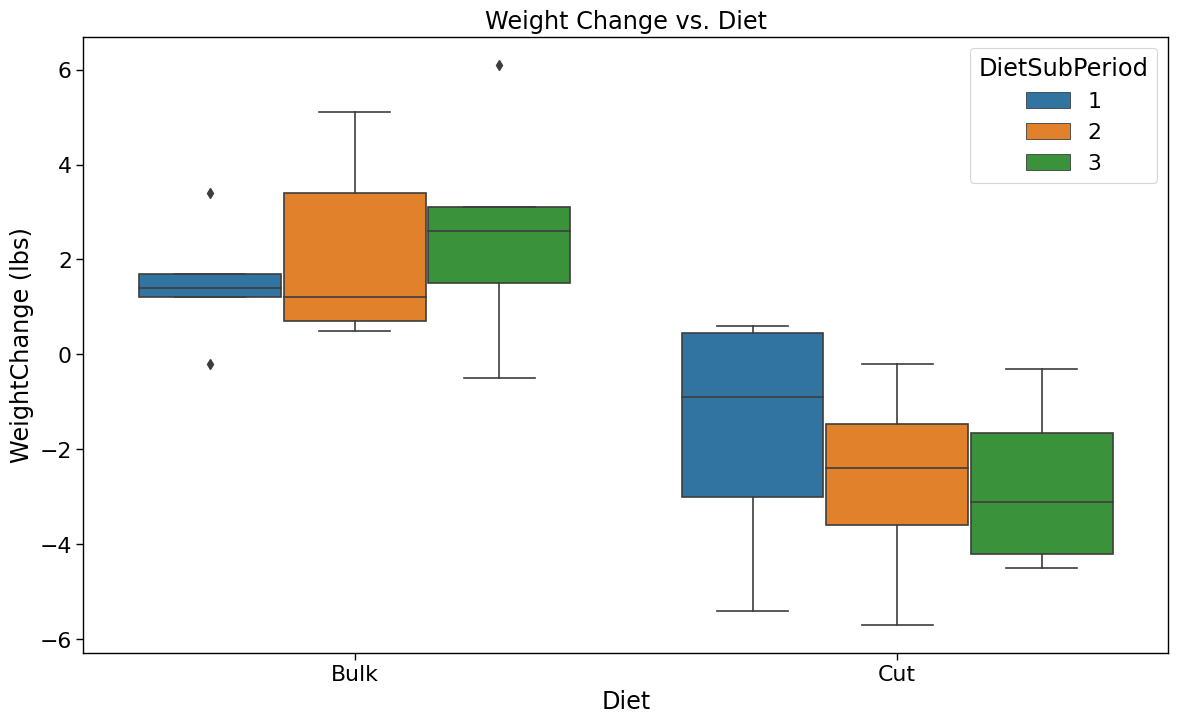

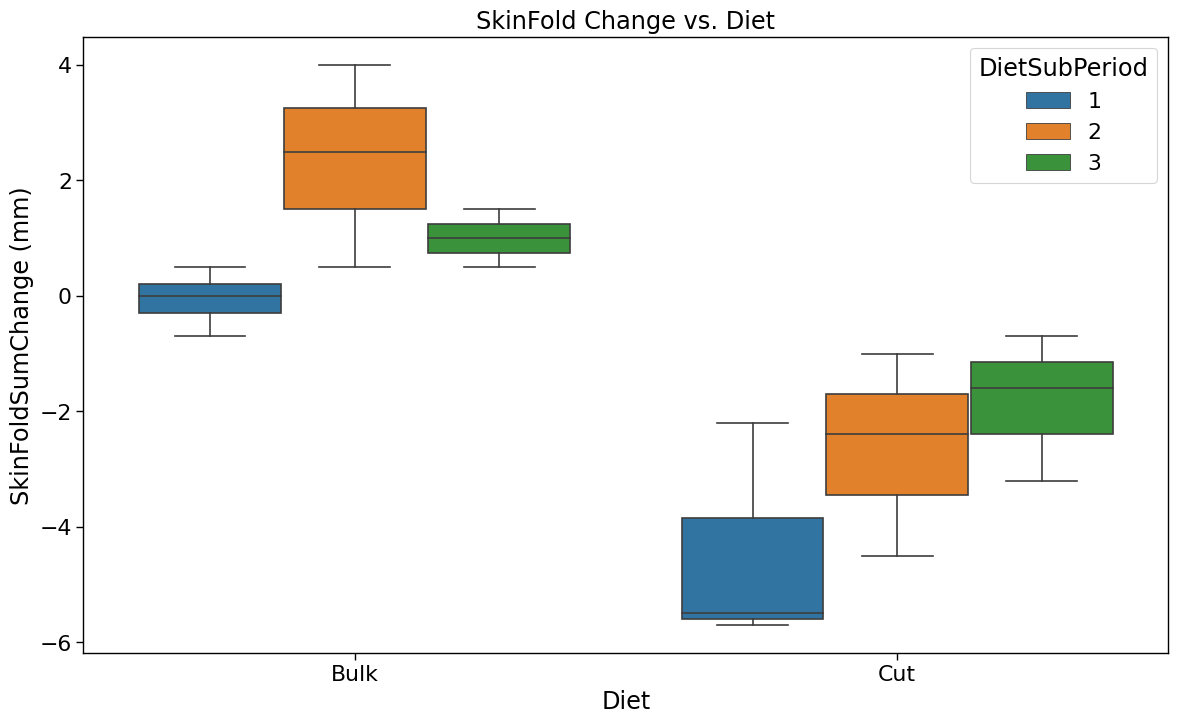

In [23]:
p = sns.boxplot(x='Diet', y="CalorieDailyAvg", hue='DietSubPeriod', data=summary_df_3)
p.set(title='Avg Calorie intake vs. Diet')
plt.show()

u = sns.boxplot(x='Diet', y="WeightChange (lbs)", hue='DietSubPeriod', data=summary_df_3)
u.set(title='Weight Change vs. Diet')
plt.show()

r = sns.boxplot(x='Diet', y="SkinFoldSumChange (mm)", hue='DietSubPeriod', data=summary_df_3)
r.set(title='SkinFold Change vs. Diet')
plt.show()

## Conclusion <a class="anchor" id="chapter6"></a>

Given the subjective increase in difficulty I have noticed during that last third or so of a cutting (fat loss) diet, it is not surprising to see the data also suggests this. As shown by the box plots for calorie intake, caliper readings & weight, as the cut progresses it appears weight loss is maintained or even increases, but caliper readings do not decrease as much compared to the previous periods. This may indicate a shift from fat loss to more muscle loss. The change in the P-ratio (fat loss / muscle loss) shifting to more muscle loss as one gets leaner is well established in research, but should be mitigated at all costs by changes in the training program and/or by reducing the magnitude of energy deficit as the person becomes leaner.

A limitation to this analysis is the data collected for the skin fold readings only came from three sites on the body. Since the site of fat loss can vary over the course of a diet (and often does for most people), it may be the case fat loss shifts to areas of my body I am unable to measure using skin fold calipers on my own (such as my back and arms).

In order to gain a better understanding as to whether or not I am overly aggressive or becoming too lean during the last period of cut, I will be constructing a dataframe that incorporates my training exercises and how my strength progresses on certain exercises over the course of cutting and bulking. It would also be advantageous (although less practical) to add a second method of body fat measurement over time such as a DXA scan.

Moving forward, I will most likely be reducing the magnitude of my energy deficit during the last month or so of a cut (when I'm around 12% body fat) or simply stop the cut prior to reaching the same skin fold measurements as before depending on how satisfied I am with the level of leanness I have obtained.